In [ ]:
!git clone https://github.com/jkenavdekar/Track_one.git

Cloning into 'Track_one'...
remote: Enumerating objects: 17097, done.
remote: Total 17097 (delta 0), reused 0 (delta 0), pack-reused 17097
Receiving objects: 100% (17097/17097), 215.68 MiB | 39.28 MiB/s, done.
Checking out files: 100% (17170/17170), done.


In [ ]:
!ls Track_one

driving_log.csv  IMG


In [ ]:
#!pip3 install imgaug

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras 
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
import cv2
import pandas as pd
import random
import ntpath
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from imgaug import augmenters as iaa

##Loading The Dataset

In [ ]:
datadir = 'Track_one'
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names = columns)
pd.set_option('display.max_colwidth', -1)
data.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  after removing the cwd from sys.path.


center  ...     speed
0  C:\Users\jayke\Downloads\autonomous_car_training\IMG\center_2020_12_27_11_11_57_178.jpg  ...  0.000082
1  C:\Users\jayke\Downloads\autonomous_car_training\IMG\center_2020_12_27_11_11_57_279.jpg  ...  0.000078
2  C:\Users\jayke\Downloads\autonomous_car_training\IMG\center_2020_12_27_11_11_57_382.jpg  ...  0.000080
3  C:\Users\jayke\Downloads\autonomous_car_training\IMG\center_2020_12_27_11_11_57_484.jpg  ...  0.000078
4  C:\Users\jayke\Downloads\autonomous_car_training\IMG\center_2020_12_27_11_11_57_585.jpg  ...  0.000079

[5 rows x 7 columns]

In [ ]:
def path_leaf(path):
  head, tail = ntpath.split(path)
  return tail

data['center'] = data['center'].apply(path_leaf) 
data['left'] = data['left'].apply(path_leaf) 
data['right'] = data['right'].apply(path_leaf)
data.head()

center  ...     speed
0  center_2020_12_27_11_11_57_178.jpg  ...  0.000082
1  center_2020_12_27_11_11_57_279.jpg  ...  0.000078
2  center_2020_12_27_11_11_57_382.jpg  ...  0.000080
3  center_2020_12_27_11_11_57_484.jpg  ...  0.000078
4  center_2020_12_27_11_11_57_585.jpg  ...  0.000079

[5 rows x 7 columns]

[-0.96 -0.88 -0.8  -0.72 -0.64 -0.56 -0.48 -0.4  -0.32 -0.24 -0.16 -0.08
  0.    0.08  0.16  0.24  0.32  0.4   0.48  0.56  0.64  0.72  0.8   0.88
  0.96]


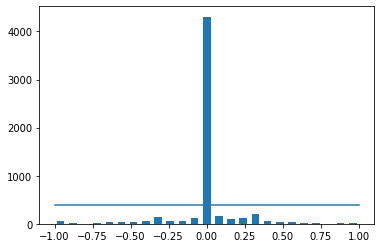

In [ ]:
bins = 25
#200 or 400
samples = 400
hist, bin = np.histogram(data['steering'], bins)
#print(hist)
#print(bin)
center = (bin[:-1]+ bin[1:])*0.5
print(center)
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples, samples))

Data Before 5723
steering length 5723
Remove List 3907
Data after 1816


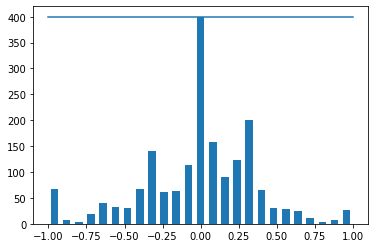

In [ ]:
print('Data Before', len(data))
print('steering length', len(data['steering']))
remove_list = []
for j in range(bins):
  list_ = []
  for i in range(len(data['steering'])):
    if data['steering'][i] >= bin[j] and data['steering'][i] <= bin[j+1]:
      list_.append(i)
  list_ = shuffle(list_)
  list_ = list_[samples:]
  remove_list.extend(list_)

print('Remove List', len(remove_list))
data.drop(data.index[remove_list], inplace=True)
print('Data after', len(data))

hist, _ = np.histogram(data['steering'], (bins))  
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples, samples))


##just a test code!

[2 0 1 0 1]
[1.  1.4 1.8 2.2 2.6 3. ]
[1.2 1.6 2.  2.4 2.8]
[]


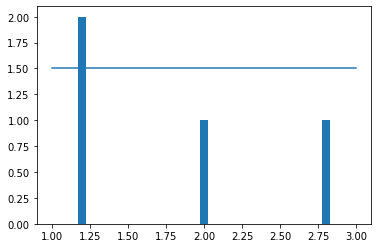

In [ ]:
h, b =np.histogram([1, 2, 1, 3], bins=5)
print(h)
print(b)
c = (b[:-1]+ b[1:])*0.5
print(c)
plt.bar(c, h, width=0.05)
plt.plot((1.0, 3.0),(1.5, 1.5))
#plt.hist([1, 2, 1, 3], bins=5)
print(h[5:])


## Train - Validation split

In [ ]:
def load_img_steering(datadir, df):
  image_path = []
  steering = []
  for i in range(len(data)):
    index_data = data.iloc[i]
    center, left, right = index_data[0], index_data[1], index_data[2]
    #center image
    image_path.append(os.path.join(datadir, center.strip()))
    steering.append(float(index_data[3]))
    #left image
    image_path.append(os.path.join(datadir, left.strip()))
    steering.append(float(index_data[3])+0.15)
    #right image
    image_path.append(os.path.join(datadir, right.strip()))
    steering.append(float(index_data[3])-0.15)

  image_paths = np.asarray(image_path)
  steerings = np.asarray(steering)
  return image_paths, steerings

image_paths, steerings = load_img_steering(datadir + '/IMG', data)




In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(image_paths, steerings, test_size = 0.2, random_state = 6)

Text(0.5, 1.0, 'Validation Set')

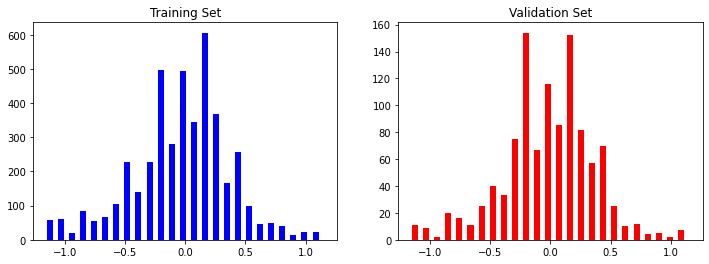

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(y_train, bins = bins, width = 0.05, color = 'blue')
axes[0].set_title('Training Set')
axes[1].hist(y_valid, bins = bins, width = 0.05, color = 'red')
axes[1].set_title('Validation Set')


##Implement Data Augmentation: zoom, panning, brightness, flip

In [ ]:
def zoom(image):
  zoom = iaa.Affine(scale=(1,1.3))
  image = zoom.augment_image(image)
  return image

Text(0.5, 1.0, 'Zoomed Image')

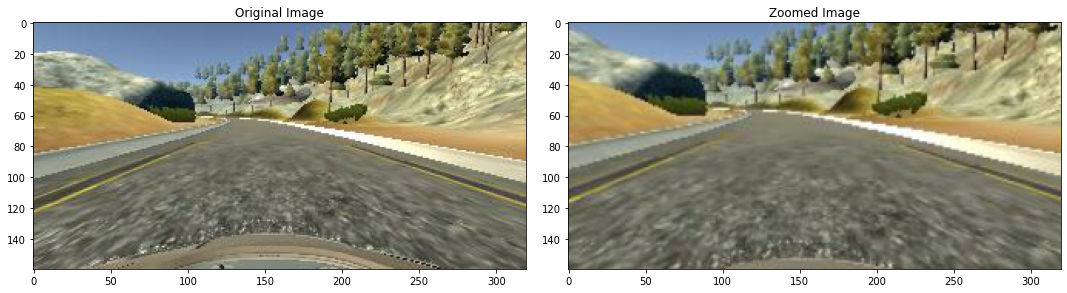

In [ ]:
image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
zoomed_image = zoom(original_image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original Image')

axs[1].imshow(zoomed_image)
axs[1].set_title('Zoomed Image')

In [ ]:
def pan(image):
  pan = iaa.Affine(translate_percent={"x" : (-0.1, 0.1), "y" : (-0.1, 0.1)})
  image = pan.augment_image(image)
  return image

In [ ]:
def brighten(image):
  brightness = iaa.Multiply((0.2, 1.2))
  image = brightness.augment_image(image)
  return image

Text(0.5, 1.0, 'Darkened Image')

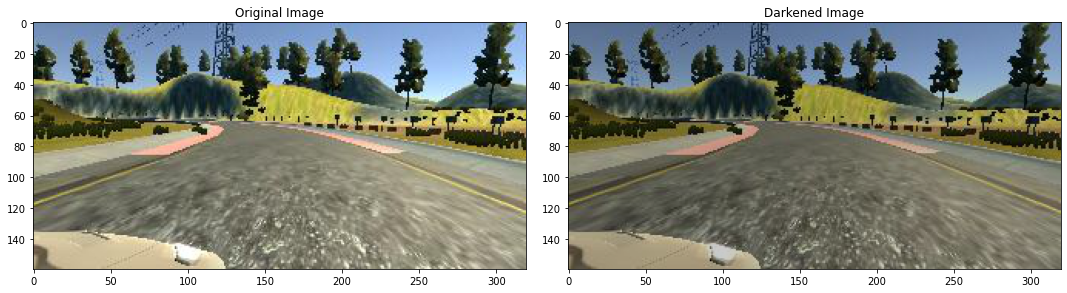

In [ ]:
image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
panned_image = pan(original_image)
bright_image = brighten(original_image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original Image')

#axs[1].imshow(panned_image)
#axs[1].set_title('Panned Image')

axs[1].imshow(bright_image)
axs[1].set_title('Darkened Image')

In [ ]:
def flip(image, steering_angle):
  image = cv2.flip(image, 1)
  steering_angle = -steering_angle
  return image, steering_angle

Text(0.5, 1.0, 'Flipped Image - steering angle: 0.7506894000000001')

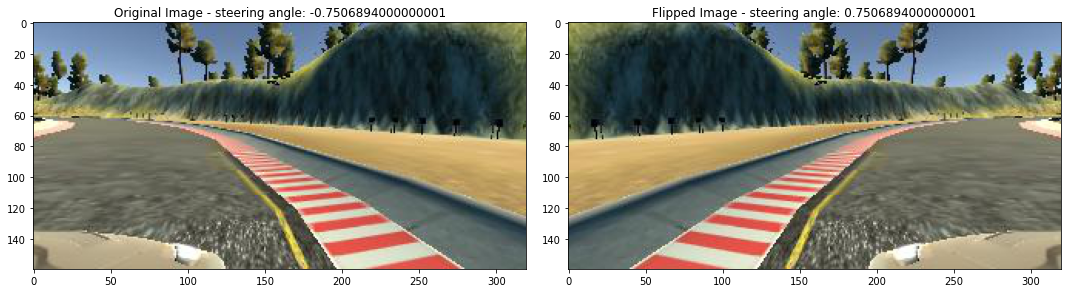

In [ ]:
index = random.randint(0, 1000)
image = image_paths[index]
steering_angle = steerings[index]

original_image = mpimg.imread(image)
flipped_image, f_angle = flip(original_image, steering_angle)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original Image - ' + 'steering angle: ' + str(steering_angle) )

axs[1].imshow(flipped_image)
axs[1].set_title('Flipped Image - ' + 'steering angle: ' + str(f_angle) )

In [ ]:
def random_augment(image, steering_angle):
  image = mpimg.imread(image)
  if np.random.rand() < 0.5:
    image = pan(image)
  if np.random.rand() < 0.5:
    image = zoom(image)
  if np.random.rand() < 0.5:
    image = brighten(image)
  if np.random.rand() < 0.5:
    image, steering_angle = flip(image, steering_angle)

  return image, steering_angle

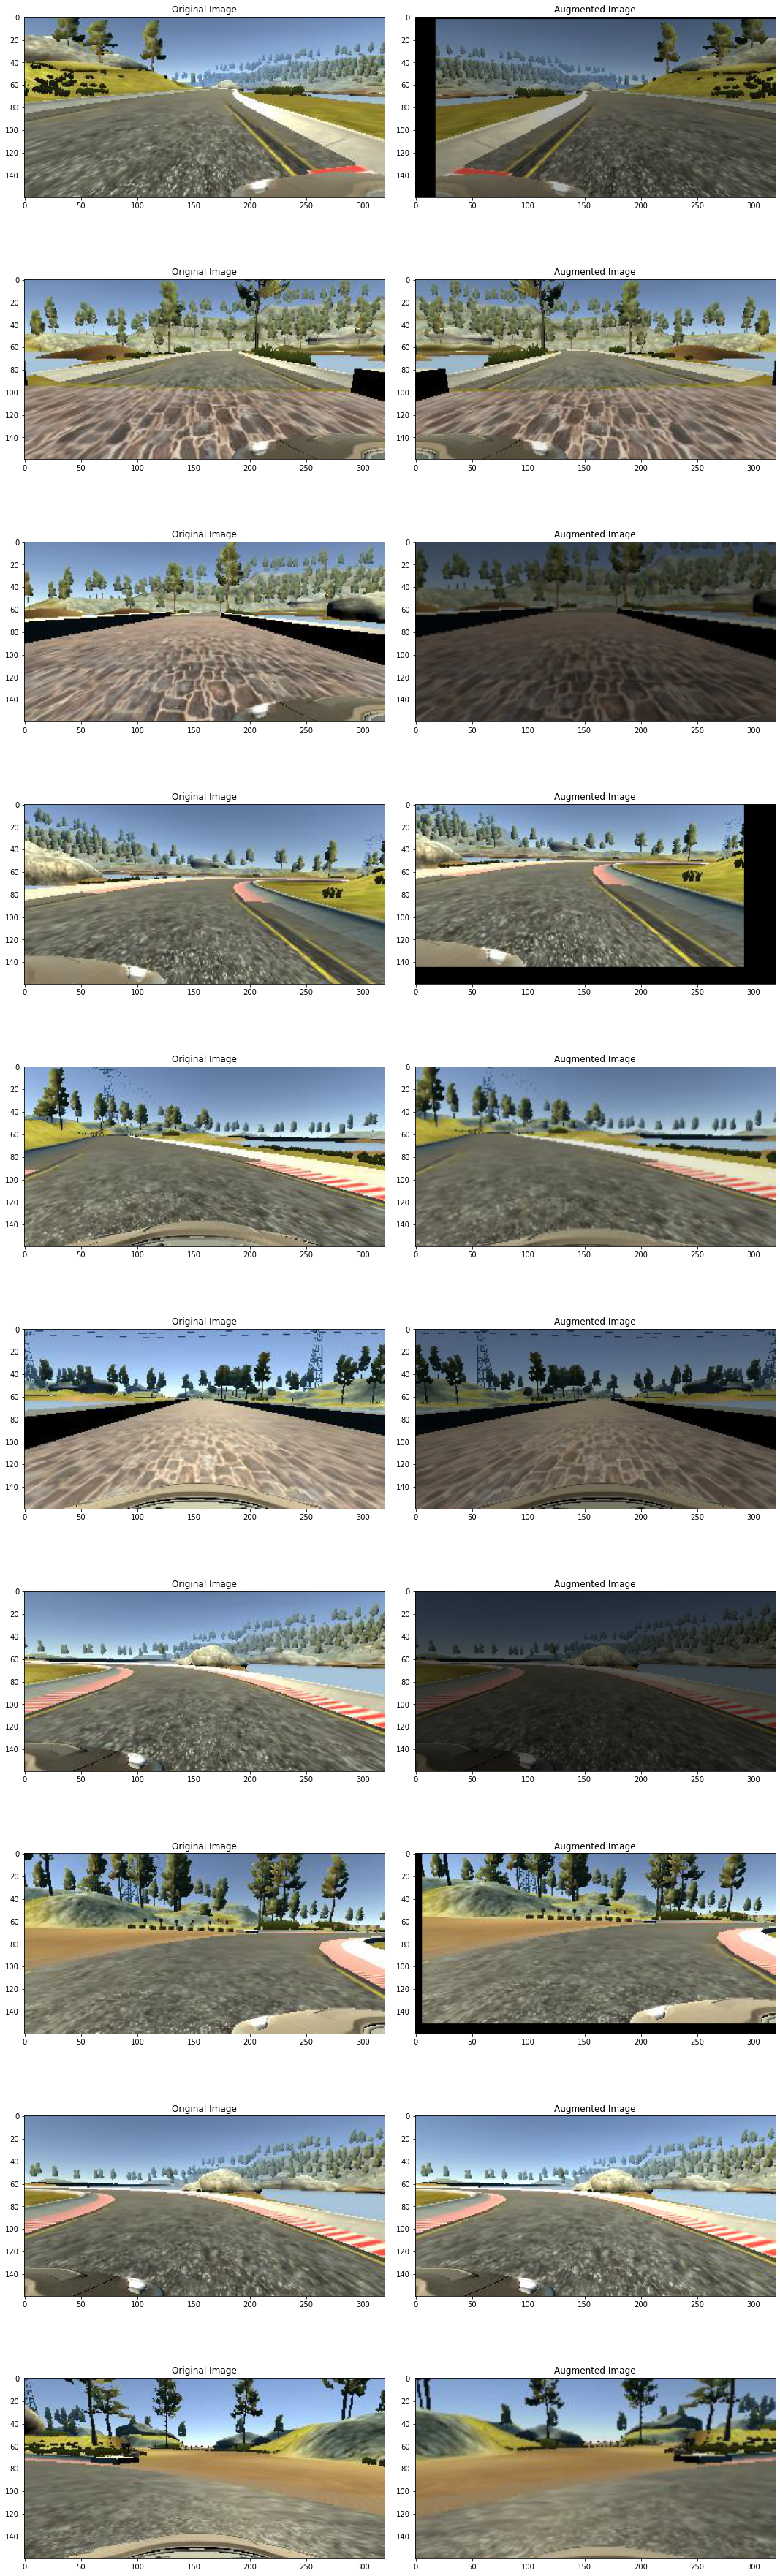

In [ ]:
ncol = 2
nrow = 10
 
fig, axs = plt.subplots(nrow, ncol, figsize=(15, 50))
fig.tight_layout()
 
for i in range(10):
  randnum = random.randint(0, len(image_paths) - 1)
  random_image = image_paths[randnum]
  random_steering = steerings[randnum]
    
  original_image = mpimg.imread(random_image)
  augmented_image, steering = random_augment(random_image, random_steering)
    
  axs[i][0].imshow(original_image)
  axs[i][0].set_title("Original Image")
  
  axs[i][1].imshow(augmented_image)
  axs[i][1].set_title("Augmented Image")

## Image preprocessing

In [ ]:
def img_preprocess(img):
  img = img[60:135, :, :]
  img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
  img = cv2.GaussianBlur(img, (3,3), 0)
  img = cv2.resize(img, (200, 66))
  img = img/255.
  return img

(66, 200, 3)


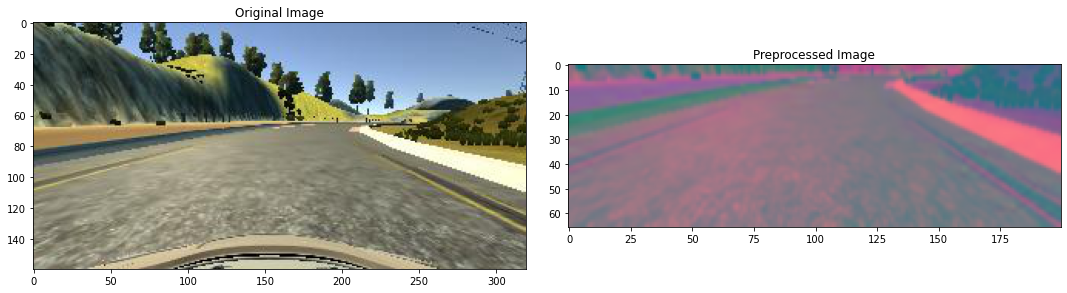

In [ ]:
image = X_train[100]
#print(image)
original = mpimg.imread(image)
#print(original)
preprocessed = img_preprocess(original)
#print(preprocessed)

fig, axes = plt.subplots(1, 2, figsize=(15,10))
fig.tight_layout()
axes[0].imshow(original)
axes[0].set_title('Original Image')
axes[1].imshow(preprocessed)
axes[1].set_title('Preprocessed Image')
print(preprocessed.shape)

## Batch generator

In [ ]:
def batch_generator(image_paths, steering_ang, batch_size, istraining):
  
  while True:
    batch_img = []
    batch_steering = []
    
    for i in range(batch_size):
      random_index = random.randint(0, len(image_paths) - 1)
      
      if istraining:
        im, steering = random_augment(image_paths[random_index], steering_ang[random_index])
     
      else:
        im = mpimg.imread(image_paths[random_index])
        steering = steering_ang[random_index]
      
      im = img_preprocess(im)
      batch_img.append(im)
      batch_steering.append(steering)
    yield (np.asarray(batch_img), np.asarray(batch_steering)) 

Text(0.5, 1.0, 'Validation Image')

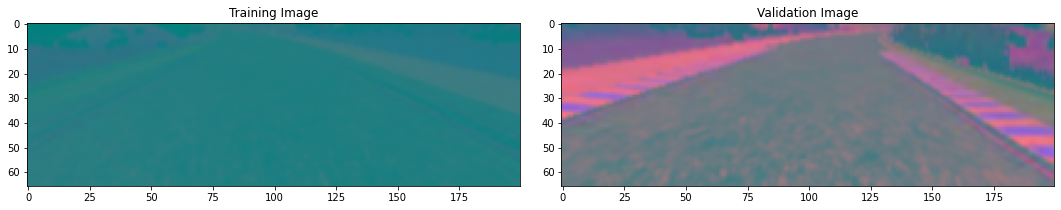

In [ ]:
x_train_gen, y_train_gen = next(batch_generator(X_train, y_train, 1, 1))
x_valid_gen, y_valid_gen = next(batch_generator(X_valid, y_valid, 1, 0))
 
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
 
axs[0].imshow(x_train_gen[0])
axs[0].set_title('Training Image')
 
axs[1].imshow(x_valid_gen[0])
axs[1].set_title('Validation Image')

## Just another test code!

In [ ]:
#Not required after we define batch generator
t_list = []
for i in range(len(X_train)):
  source = mpimg.imread(X_train[i])
  result = img_preprocess(source)
  t_list.append(result)

X_train = np.asarray(t_list)
print(X_train.shape)

(3876, 66, 200, 3)


In [ ]:
#Not required after we define batch generator
v_list = []
for i in range(len(X_valid)):
  source = mpimg.imread(X_valid[i])
  result = img_preprocess(source)
  v_list.append(result)

X_valid = np.asarray(v_list)
print(X_valid.shape)

(969, 66, 200, 3)


(3876, 66, 200, 3)


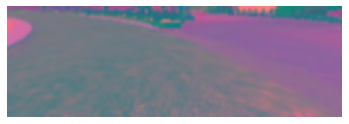

In [ ]:
plt.imshow(X_train[random.randint(0, len(X_train)-1)])
plt.axis('off')
print(X_train.shape)

##Training Part 1: using only collected training data

<img src="https://miro.medium.com/max/1160/1*JKDXxMxiEtiySMg1yeTibw.png" width="500" alt="CNN architecture">

In [ ]:
def nvidia_model():
  model = Sequential()
  
  model.add(Conv2D(24, kernel_size=(5,5), strides=(2,2), input_shape=(66,200,3),activation='elu'))
  
  model.add(Conv2D(36, kernel_size=(5,5), strides=(2,2), activation='elu'))
  model.add(Conv2D(48, kernel_size=(5,5), strides=(2,2), activation='elu'))
  model.add(Conv2D(64, kernel_size=(3,3), activation='elu'))
  model.add(Conv2D(64, kernel_size=(3,3), activation='elu'))
  model.add(Dropout(0.5))
  
  model.add(Flatten())

  model.add(Dense(100, activation='elu'))
  model.add(Dropout(0.5))
  
  model.add(Dense(50, activation='elu'))
  model.add(Dropout(0.5))

  model.add(Dense(10, activation ='elu'))
  model.add(Dropout(0.5))

  model.add(Dense(1))
  
  optimizer= Adam(lr=1e-3)
  model.compile(loss='mse', optimizer=optimizer)
  
  return model

In [ ]:
model = nvidia_model()
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 1, 18, 64)         36928     
_________________________________________________________________
dropout_2 (Dropout)          (None, 1, 18, 64)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1152)             

In [ ]:
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_valid, y_valid), batch_size=100, verbose=1, shuffle=1)

Epoch 1/30
39/39 [==============================] - 23s 572ms/step - loss: 0.6594 - val_loss: 0.1772
Epoch 2/30
39/39 [==============================] - 22s 567ms/step - loss: 0.1860 - val_loss: 0.1503
Epoch 3/30
39/39 [==============================] - 22s 567ms/step - loss: 0.1661 - val_loss: 0.1381
Epoch 4/30
39/39 [==============================] - 22s 565ms/step - loss: 0.1498 - val_loss: 0.1295
Epoch 5/30
39/39 [==============================] - 22s 567ms/step - loss: 0.1461 - val_loss: 0.1280
Epoch 6/30
39/39 [==============================] - 22s 564ms/step - loss: 0.1439 - val_loss: 0.1104
Epoch 7/30
39/39 [==============================] - 22s 565ms/step - loss: 0.1329 - val_loss: 0.1143
Epoch 8/30
39/39 [==============================] - 22s 567ms/step - loss: 0.1213 - val_loss: 0.1096
Epoch 9/30
39/39 [==============================] - 22s 565ms/step - loss: 0.1246 - val_loss: 0.1052
Epoch 10/30
39/39 [==============================] - 22s 565ms/step - loss: 0.1245 - val_lo

Text(0.5, 0, 'Epoch')

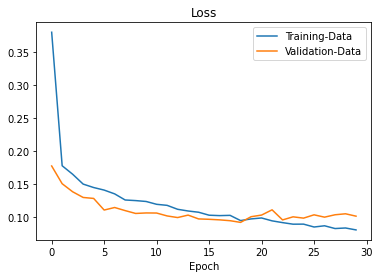

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Training-Data', 'Validation-Data'])
plt.title('Loss')
plt.xlabel('Epoch')

In [ ]:
model.save('model.h5')

In [ ]:
from google.colab import files
files.download('model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Final Training**

##Training Part 2 : with Data Augmentation

In [ ]:
def nvidia_model():
  model = Sequential()
  
  model.add(Conv2D(24, kernel_size=(5,5), strides=(2,2), input_shape=(66,200,3),activation='elu'))
  
  model.add(Conv2D(36, kernel_size=(5,5), strides=(2,2), activation='elu'))
  model.add(Conv2D(48, kernel_size=(5,5), strides=(2,2), activation='elu'))
  model.add(Conv2D(64, kernel_size=(3,3), activation='elu'))
  model.add(Conv2D(64, kernel_size=(3,3), activation='elu'))
  
  model.add(Flatten())

  model.add(Dense(100, activation='elu'))
  
  model.add(Dense(50, activation='elu'))

  model.add(Dense(10, activation ='elu'))

  model.add(Dense(1))
  
  optimizer= Adam(lr= 1e-4)
  model.compile(loss='mse', optimizer=optimizer)
  
  return model

In [ ]:
model = nvidia_model()
print(model.summary())
history = model.fit_generator(batch_generator(X_train, y_train, 100, 1),                            
                              steps_per_epoch=300, 
                              epochs=10,
                              validation_data = batch_generator(X_valid, y_valid, 100, 0),
                              validation_steps = 200,
                              verbose = 1,
                              shuffle = 1)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 1, 18, 64)         36928     
_________________________________________________________________
flatten (Flatten)            (None, 1152)              0         
_________________________________________________________________
dense (Dense)                (None, 100)              

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
300/300 [==============================] - 214s 605ms/step - loss: 0.1530 - val_loss: 0.1101
Epoch 2/10
300/300 [==============================] - 183s 613ms/step - loss: 0.1306 - val_loss: 0.0915
Epoch 3/10
300/300 [==============================] - 181s 606ms/step - loss: 0.1207 - val_loss: 0.0802
Epoch 4/10
300/300 [==============================] - 179s 598ms/step - loss: 0.1100 - val_loss: 0.0781
Epoch 5/10
300/300 [==============================] - 178s 595ms/step - loss: 0.1014 - val_loss: 0.0771
Epoch 6/10
300/300 [==============================] - 179s 598ms/step - loss: 0.0965 - val_loss: 0.0717
Epoch 7/10
300/300 [==============================] - 179s 597ms/step - loss: 0.0939 - val_loss: 0.0748
Epoch 8/10
300/300 [==============================] - 179s 599ms/step - loss: 0.0919 - val_loss: 0.0691
Epoch 9/10
300/300 [==============================] - 178s 597ms/step - loss: 0.0869 - val_loss: 0.0699
Epoch 10/10
300/300 [==============================] - 177s 593m

Text(0.5, 0, 'Epoch')

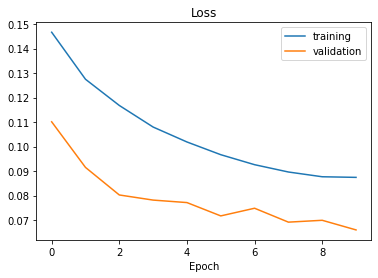

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('Epoch')

In [ ]:
model.save('model2.h5')
from google.colab import files
files.download('model2.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>